In [91]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import matplotlib.pyplot as plt 
from pandas.plotting import table 


## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
COMBINED_DISCLOSURE_DATA = "H-2A_Disclosure_Data_FY_combined_202021Q1.csv"
COMBINED_ADDENDUMS_DATA = "FOIA_2021-F-05932_raw_data_combined_202021Q1.csv"

# Load datasets

In [21]:
# load data
LOAD_LOCAL = True 
if LOAD_LOCAL:
    addendum = pd.read_csv("../FOIA_2021-F-05932_raw_data_combined_202021Q1.csv")
    disclosure = pd.read_csv ("../H-2A_Disclosure_Data_FY_combined_202021Q1.csv")
else:
    addendum = pd.read_csv(DROPBOX_DATA_PATH + COMBINED_ADDENDUMS_DATA)
    disclosure = pd.read_csv (DROPBOX_DATA_PATH + COMBINED_DISCLOSURE_DATA)
    


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,18,31,83,84,138,139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Addendum and Disclosure Data Drop Duplicate 


In [22]:
print("Addendum dropping duplicates, %s rows" % len(addendum))
addendum = addendum.drop_duplicates(["CASE_NUMBER", "SECTION_DETAILS"])
print("Addendum After dropping duplicates, %s rows" % len(addendum))

Addendum dropping duplicates, 102317 rows
Addendum After dropping duplicates, 99620 rows


In [23]:
print("Disclosure Before dropping duplicates, %s rows" % len(disclosure))
disclosure = disclosure.drop_duplicates(["CASE_NUMBER"])
print("Disclosure After dropping duplicates, %s rows" % len(disclosure))

Disclosure Before dropping duplicates, 16783 rows
Disclosure After dropping duplicates, 16774 rows


# Pre-Aggregate addendum data overview

In [ ]:
### Table

In [101]:
addendum.head(n=1)
addendum_mini=addendum.copy()
addendum_mini=addendum_mini.loc[~addendum_mini.SECTION_NUMBER.isnull()&~addendum_mini.SECTION_NAME.isnull()]
#Find the top 5 section 
addendum_mini.SECTION_NUMBER.value_counts().nlargest(5)
top5_section=["A.8a","B.6","F.2","F.1","A.11"]
addendum_mini["top5sect"] = np.where(addendum_mini.SECTION_NUMBER.isin(top5_section), True, False)
#Find An Example of Each
addendum_mini=addendum_mini[addendum_mini.top5sect==True]
addendum_mini=addendum_mini.drop_duplicates(subset='SECTION_NUMBER', keep="first")
pd.options.display.max_colwidth = 500
addendum_mini = addendum_mini[['SECTION_NAME','SECTION_NUMBER',"SECTION_DETAILS"]]
addendum_mini
addendum_mini.to_latex()

,CASE_NUMBER,SECTION_NAME,SECTION_NUMBER,SECTION_DETAILS
0,H-300-19274-066174,Meal Provision,E.1,"Employer will furnish free and convenient cooking and kitchen facilities at no cost to the worker, all of which are in working order, including refrigeration, space for food preparation, cooking accessories and utensils, appliances, and dishwashing facilities so that workers may prepare their own meals. Kitchen facilities include adequate sinks with hot and cold water under pressure. Employer will provide transportation once a week to assure workers access to stores where they can purchase g..."


A.8a    35179
B.6     30507
F.2     12260
A.11    10283
F.1      4907
Name: SECTION_NUMBER, dtype: int64

,SECTION_NAME,SECTION_NUMBER,SECTION_DETAILS
1,Job Requirements,B.6,"Three (3) months experience with references required as a beekeeper. May not have bee, pollen or honey-related allergies. Must be able to obtain a drivers license within 30 days following hire and obtain clean driving record. Must be able to lift 75 lbs. Once hired, worker may be required to take a random drug test at no cost to the worker. Testing positive or failure to comply may result in immediate termination from employment."
2,Daily Transportation,F.1,"Living & laundry facilities available. Housing will be clean and in compliance with OSHA Housing Standards at 29 CFR 1910.142 when occupied. Workers will be responsible for maintaining housing in a neat, clean manner. Housing and utilities are provided at no cost to workers who are unable to return to their place of residence the same day."
5,Pay Deductions,A.11,"Reasonable repair cost of damage from deliberate destruction, other than that caused by normal wear and tear, will be deducted from the earnings of workers found to have been responsible for damage to housing, furnishings, or equipment. No deductions will be made which would bring the employee’s hourly wage below the Federal Minimum Wage. (Reference; Internal Revenue Service Publication 51, Circular A, Agricultural Employer’s Tax Guide)\nGarnishments and levies required by law shall be deduc..."
7,Inbound/Outbound Transportation,F.2,"Alternatively, the employer may, at his or her discretion, provide transportation funds or purchase transportation tickets for the worker ahead of time. \nUpon completion of the work contract or termination of the worker’s employment without cause, the employer will cover the reasonable expenses for the worker’s return trip back to the place from which the worker came to work for the employer. Transportation payment will be equal to the most economical and reasonable common carrier transpo..."
40,Job Duties,A.8a,"16.\tWorkers may not entertain guests in employer-provided housing premises after 10:30 PM, except on Saturdays when guest hours end at 12:00 midnight. No persons, other than workers assigned by employer, may sleep in housing.\n17.\tWorkers may not deliberately restrict production or damage products/commodities.\n18.\tWorkers may not physically threaten other workers, the employer, supervisors, or members of the public with any tool or weapon. Workers who violate this rule may be subject to ..."


'\\begin{tabular}{llll}\n\\toprule\n{} &                     SECTION\\_NAME & SECTION\\_NUMBER &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      SECTION\\_DETAILS \\\\\n\\midrule\n1  &                 Job Requirements &            B.6 &                                                                 Three (3) months experience with references required as a beekeeper.  May not have bee, pollen or honey-related allergies.  Must be able to obtain a drivers license within 30 days following hire and obtain clean driving record. Must be able to lift 75 lbs. Once 

# Aggregate addendums data
- Rename Column
- Joining free text
- Removing ones with Spanish

In [102]:
# Rename Columns in aggregated addendums
addendum = addendum.rename(columns = {"SECTION_DETAILS":"JOB_DESCRIPTION"})

print("Range of text lengths are:-------------------------")
print(addendum.JOB_DESCRIPTION.astype(str).str.len().value_counts())

Range of text lengths are:-------------------------
342     1460
962     1135
539     1063
1183    1051
3131    1049
        ... 
3253       1
2632       1
2740       1
1736       1
1631       1
Name: JOB_DESCRIPTION, Length: 3463, dtype: int64


In [103]:
#Remove Job Listings that Contain Spanish Words
## rj note: not high priority, but i have some concerns about doing this 
## removal on the aggregated addendums rather than the sections
## in particular, it might make more sense to do the spanish indicator on whether a specific section
## contains spanish and then remove that section; preserving non-spanish sections of that posting
## this discards the whole post if any section contains spanish, which ends up deleting more data
spanish_words = ['compensación',
 'ocupación',
 'pago',
 'transporte',
 'reglas',
 'contrato',
 'horastrabajadores',
 'parte',
 'tarifas',
 'cuartos',
 'trabajo',
 'registros',
 'adicionales',
 'comidas',
 'empleo',
 'terminación',
 'vivienda',
 'empleador',
 'adicionales',
 'frecuencia',
 'producción',
 'liquidación',
 'comida',
 'herramientas',
 'prueba',
 'diaria',
 'tarifas',
 'parado',
 'adicionales',
 'cobertura',
 'proporcionados',
 'parte',
 'abandono',
 'deducciones',
 'causa',
 'garantías',
 'divulgación',
 'comidas',
 'política',
 'disciplina',
 'despidos',
 'derechos',
 'imposibilidad',
 'detalles',
 'divulgación',
 'bloqueo',
 'abandono',
 'ganancias',
 'cobertura',
 'pedidos',
 'pago',
 'oportunidad',
 'trabajo']

addendum['is_contains_spanish'] = np.where(addendum.JOB_DESCRIPTION.str.contains('|'.join(spanish_words)),
                                              True, False)

addendum_eng = addendum[~addendum.is_contains_spanish].copy()
print("Removing addendums with any spanish takes us from {} jobs to {} jobs".format(
        len(addendum.CASE_NUMBER.unique()),
        len(addendum_eng.CASE_NUMBER.unique())))


Removing addendums with any spanish takes us from 13535 jobs to 13143 jobs


In [104]:
#Concatenating English Job Lisitngs from Same Case

pd.set_option('display.max_colwidth', None)
addendum_eng_agg = addendum_eng.groupby(['CASE_NUMBER'])['JOB_DESCRIPTION'].apply(lambda text: ' || '.join(text)).astype(str).str.replace('\\n', '',
                                                                                                                                         regex = True).reset_index()
print("After pasting together addendums from same case, %s rows" % len(addendum_eng_agg))
assert len(addendum_eng_agg) == len(addendum_eng.CASE_NUMBER.unique())


addendum_eng_agg.head(2)

After pasting together addendums from same case, 13143 rows


CASE_NUMBER  \
0  H-300-19274-066154   
1  H-300-19274-066174   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [105]:
print("After aggregation, addendum lengths are:------------")
print(addendum_eng_agg.JOB_DESCRIPTION.astype(str).str.len().value_counts())


addendum_eng_agg['raw_text_length'] = addendum_eng_agg.JOB_DESCRIPTION.astype(str).str.len()

After aggregation, addendum lengths are:------------
2907    372
5568    367
1204    339
7953    323
8888    231
       ... 
4899      1
793       1
2349      1
4398      1
4198      1
Name: JOB_DESCRIPTION, Length: 5214, dtype: int64


In [106]:
## Above code modified from fifth answer at https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
## because original groupby was including a bunch of linebreaks

# Merge the addendums data to disclosure data

- Clean up state in the disclosure data
- Create indicate for TRLA catchment area
- Create diff merges

RJ note: originally, this had a lot of stuff related to the disclosure data but since we're doing a left join of addendums onto disclosures, and comparing jobs in two categories---"left only" (disclosure with no addendum) and "both" (disclosure with addendum)---we can delete most of the disclosure stuff post merge and just use left-joined df

In [107]:

#Replace EMPLOYER_STATE NA with employer_poc_state State is there's a value but left NA if both of them are NA
disclosure['EMPLOYER_STATE'] =disclosure.EMPLOYER_STATE.astype("string")
print("number of NA in EMPLOYER_STATE column before allowing employer_poc_state to count as state")
disclosure['EMPLOYER_STATE'].isna().sum()
disclosure['EMPLOYER_POC_STATE'] =disclosure.EMPLOYER_POC_STATE.astype("string")
disclosure.EMPLOYER_STATE = disclosure.EMPLOYER_STATE.fillna(disclosure.EMPLOYER_POC_STATE)
print("number of NA in EMPLOYER_STATE column after allowing employer_poc_state to count as state")
disclosure['EMPLOYER_STATE'].isna().sum()




number of NA in EMPLOYER_STATE column before allowing employer_poc_state to count as state


16

number of NA in EMPLOYER_STATE column after allowing employer_poc_state to count as state


12

In [108]:
# Label TRLA Catchment State VS Remaining States
## rj note- isin more efficient than long or chain
TRLA_catchment = ["TX", "MS", "AL", "TN", "KY", "LA"]
disclosure["TRLA"] = np.where(disclosure.EMPLOYER_STATE.isin(TRLA_catchment), True, False)
disclosure.TRLA.value_counts(normalize = True)

False    0.713843
True     0.286157
Name: TRLA, dtype: float64

In [118]:
merged_data_left = pd.merge(disclosure,
                             addendum_eng_agg,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "left",
                             indicator = "case_merge_status")
merged_data_left.case_merge_status.value_counts()

both          13127
left_only      3647
right_only        0
Name: case_merge_status, dtype: int64

# Diagnostics of ones with and without english addendums

In [119]:
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

if merged_data_left.dtypes['WAGE_OFFER'] != "float64":
      
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace('$', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace(',', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].astype(float)
        
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

In [124]:
## add more informative column
merged_data_left['case_merge_status_descriptive'] = np.where(merged_data_left.case_merge_status == 
                                                        "left_only",
                                                        "No English addendum",
                                                        "English addendum")
merged_data_left_stats=merged_data_left.groupby('case_merge_status_descriptive').agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
        "PIECE_RATE_OFFER": ["median"],
        "TOTAL_OCCUPANCY" : ["median"],
        "LIFTING_AMOUNT" : ["median"],
        "TRLA": np.mean} 
        )
merged_data_left_stats
merged_data_left_stats.to_latex()
#percentage of non TRLA states is higher
#compare wages? is it that there's lower wage rate so there's no listing?



,WAGE_OFFER,TOTAL_WORKERS_NEEDED,ANTICIPATED_NUMBER_OF_HOURS,PIECE_RATE_OFFER,TOTAL_OCCUPANCY,LIFTING_AMOUNT,TRLA
,median,median,median,median,median,median,mean
case_merge_status_descriptive,,,,,,,
English addendum,13.48,6.0,40.0,0.0,8.0,60.0,0.280643
No English addendum,13.13,4.0,40.0,0.0,6.0,50.0,0.306005


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} & WAGE\\_OFFER & TOTAL\\_WORKERS\\_NEEDED & ANTICIPATED\\_NUMBER\\_OF\\_HOURS & PIECE\\_RATE\\_OFFER & TOTAL\\_OCCUPANCY & LIFTING\\_AMOUNT &      TRLA \\\\\n{} &     median &               median &                      median &           median &          median &         median &      mean \\\\\ncase\\_merge\\_status\\_descriptive &            &                      &                             &                  &                 &                &           \\\\\n\\midrule\nEnglish addendum              &      13.48 &                  6.0 &                        40.0 &              0.0 &             8.0 &           60.0 &  0.280643 \\\\\nNo English addendum           &      13.13 &                  4.0 &                        40.0 &              0.0 &             6.0 &           50.0 &  0.306005 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Plot breakdown of addendums by TRLA or not 

### Pie chart

In [112]:
merged_data_left.case_merge_status.value_counts()

both          13127
left_only      3647
right_only        0
Name: case_merge_status, dtype: int64

[2531, 1116]

[9443, 3684]

([<matplotlib.patches.Wedge at 0x7f376cdd90a0>,
 [Text(-0.6296613361890455, 0.9019570952704047, 'Non-TRLA'),
  Text(0.6296613361890454, -0.9019570952704048, 'TRLA')],
 [Text(-0.3434516379212975, 0.4919765974202207, '69.4%'),
  Text(0.34345163792129746, -0.49197659742022076, '30.6%')])

Text(0.5, 1.0, 'Jobs without English addendums\n(not in text analysis)')

Text(0.5, 1.0, 'Jobs with English addendums\n(in text analysis)')

([<matplotlib.patches.Wedge at 0x7f376c8e9fd0>,
 [Text(-0.6994530370440513, 0.8489790627393901, 'Non-TRLA'),
  Text(0.6994531165312045, -0.8489789972518669, 'TRLA')],
 [Text(-0.3815198383876643, 0.46307948876694, '71.9%'),
  Text(0.3815198817442933, -0.4630794530464728, '28.1%')])

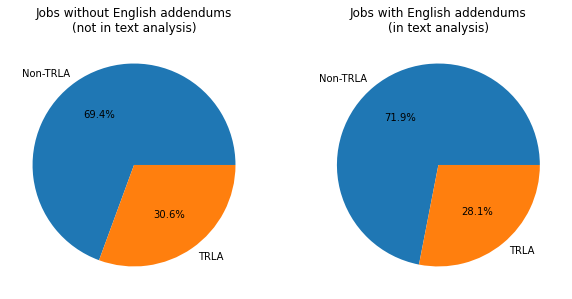

In [113]:
no_add = [merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (merged_data_left.TRLA)].shape[0]]
no_add

add = [merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (merged_data_left.TRLA)].shape[0]]
add
labels = ['Non-TRLA', 'TRLA'] 
fig, (plt1,plt2) = plt.subplots(1,2,figsize=(10,10))
plt1.pie(no_add, labels=labels, autopct='%1.1f%%')
plt1.set_title("Jobs without English addendums\n(not in text analysis)")
plt2.set_title("Jobs with English addendums\n(in text analysis)")
plt2.pie(add, labels=labels, autopct='%1.1f%%')
## save to output dir
fig.savefig("../output/addendum_comparison.png")

# Write outputs for next script

- pkl and csv (in case linebreak) of inner join between (1) disclosure and (2) aggregated, English-only addendums

In [48]:
## same join as above but inner join rather than left join
merged_data_inner = pd.merge(disclosure,
                             addendum_eng_agg,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "inner")
merged_data_inner.shape

## final check on length stuff
merged_data_inner[["raw_text_length",
             "JOB_DESCRIPTION"]].sort_values(by = "raw_text_length", ascending = False).head(2)

    

(13127, 143)

raw_text_length  \
3899           167868   
3504           104637   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [49]:
## write pkl and csv form to Dropbox folder
if LOAD_LOCAL:
    merged_data_inner.to_csv("../merged_addendums_jobdisclosures.csv",
                        index = False)
    merged_data_inner.to_pickle("../merged_addendums_jobdisclosures.pkl")
else:
    merged_data_inner.to_csv(DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.csv",
                        index = False)
    merged_data_inner.to_pickle(DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.pkl")